In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

## Oppgave 1


#### 1 a)

#### 1 b)

In [18]:
def polymer(N) -> list[int]:
    """
    Function that returns a list of integers representing the polymer with each element being a touple with the x and y coordinates of the monomer
    :param N: int
    :return: list[int]
    """
    return [(0, i) for i in range(N)]

#### 1 d)

In [35]:
# Method to display the polymer
def display_polymer(polymer_list: list[int]) -> None:
    """
    Function that displays the polymer in a grid
    :param polymer_list: list[int]
    :return: None
    """
    # Adjust grid boundaries to include all monomers
    grid_size = 2 * len(polymer_list) + 1
    offset = len(polymer_list)
    x = np.linspace(-offset, offset, grid_size)
    X, Y = np.meshgrid(x, x)
    
    Z = np.zeros(X.shape)

    # Calculate intensity values for each monomer (stronger towards the end)
    for i, (x, y) in enumerate(polymer_list):
        intensity = i / (len(polymer_list) - 1) + 0.05
        Z[x + offset, y + offset] = intensity

    # Define a purple colormap
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "purple"])

    plt.pcolormesh(X, Y, Z, cmap=cmap)
    plt.show()

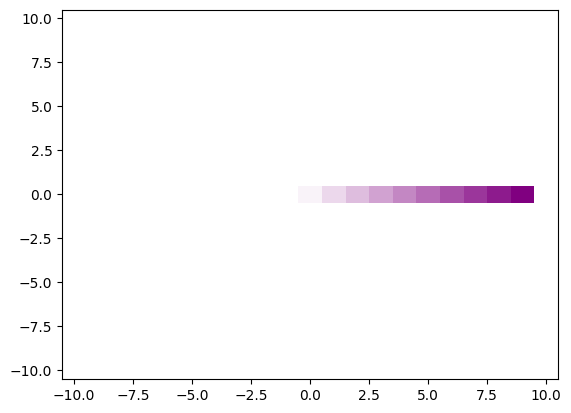

In [36]:
# Test the new Polymer function and display function
polymer_list = polymer(10)

display_polymer(polymer_list)


In [28]:
len(polymer_list)

10